# Animations of Root Finding

Animations of simple implementations of the bisection algorithm and the secant method are provided.  These algorithms are implemented in a very simple, non-robust way, to highlight some of their features and failings.

## Note:

To run in Jupyter Lab I think you need to install the `ipywidgets` Jupyter Lab extension and `ipympl`.  Both of these are available from `Anaconda`. Also see the [documentation](https://ipywidgets.readthedocs.io/en/latest/index.html) for `ipywidgets` for more information.  In particular the *Installation* section discusses the extension for Jupyter Lab. If you install through `Anaconda`, I think this notebook will "just work" (though you may need to completely restart jupyter lab, not just the kernel, after you install ipympl).

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from IPython.display import display
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)

## Implementation

The implementation of these algorithms in an over engineered manner, yet still without a clearly separated api.  The details of the implementation are not important and will not be the subject of this course.  In particular, much more of the Python language is used here than we will probably even mention or see again in the course.  *You are not expected to understand or study this code.*

In [2]:
class RootAlgorithm :
    """
    Base class for a root finding algorithm.
    """
    def __init__(self, func, a, b) :
        """
        For us a root finding algorithm requires a function, f(x).  The algorithm will find
        the value of x for which f(x)=0.
        In this implementation `func` is a callable that takes one argument.
        `a` and `b` are two initial guesses for x to use for the root finding algorithm.
        Though we will refer to these as "brackets" sometimes, we do not require the root
        to be bracketed.
        """
        self.name = None
        self.func = func
        self.xguess = None # This must be updated in a subclass.
        self.reset(a, b)
    
    def reset(self, a, b) :
        """
        Reset the root finding algorithm back to its starting state.
        """
        self.step = 1
        self.set_bracket(a, b)
        
    def set_bracket(self, a, b) :
        """
        Set the values of `a` and `b` for the algorithm.
        """
        self.a = a
        self.b = b
        self.calculate_guess()
    
    def do_step(self) :
        """
        Perform one step of the algorithm.
        """
        self.update_state()
        self.calculate_guess()
        self.step += 1

    def extra_curve_yvals(self, x) :
        """
        Return the y values for an extra curve to include in a plot calculated at the values, `x`.
        Here `x` may be a single number of a numpy array.
        """
        return None
    
    def calculate_guess(self) :
        """
        Calculate the guess for `x` based on the current values of `a` and `b`.
        This is algorithm dependent and must be provided in a subclass.
        """
        pass
    
    def update_state(self) :
        """
        Update the state of the root finding.
        This means, update the values of `a` and `b`.
        This is algorithm dependent and must be provided in a subclass.
        """
        pass

class RootBisection(RootAlgorithm) :
    """
    Very simplistic bisection algorithm.
    This does not enforce bracketing (so that we can abuse it).
    Never use this for actual root finding!
    """
    def __init__(self, func, a, b) :
        super().__init__ (func, a, b)
        self.name = 'Bisection'

    def calculate_guess(self) :
        self.xguess = (self.a + self.b) / 2
    
    def update_state(self) :
        if self.func(self.a) * self.func(self.xguess) > 0 :
            self.a = self.xguess
        else :
            self.b = self.xguess
        
class RootSecant(RootAlgorithm) :
    """
    Very simplistic secant method algorithm.
    This does not enforce bracketing so can fail spectacularly.
    Never use this for actual root finding!
    """
    def __init__(self, func, a, b) :
        super().__init__ (func, a, b)
        self.name = 'Secant Method'

    def extra_curve_yvals(self, x) :
        fa = self.func(self.a)
        fb = self.func(self.b)
        m = (fb - fa) / (self.b - self.a)
        y = m*(x-self.a) + fa
        return y
        
    def calculate_guess(self) :
        fa = self.func(self.a)
        fb = self.func(self.b)
        self.xguess = self.b - (self.b-self.a)*fb/(fb-fa)
        
    def update_state(self) :
        self.a = self.b
        self.b = self.xguess

Define a function class. This is not really necessary since functions are already objects and we could just add information to them.

In [3]:
class Function :
    """
    Wrapper for a function.
    """
    def __init__(self) :
        self.title = None
        self.expected = None
    
    def __call__(self, x) :
        pass
    
class Function_Sqrt2(Function) :
    """
    Function for calculating the sqrt(2) using root finding.
    The actual function is x^2-2.
    """
    def __init__(self) :
        super().__init__()
        self.title = r'$\sqrt{2}$'
        self.expected = np.sqrt(2)
        
    def __call__(self, x) :
        return x*x - 2
    
class Function_Tanh(Function) :
    """
    Function for finding the root of tanh(x-1).
    """
    def __init__(self) :
        super().__init__()
        self.title = r'$\tanh(x-1)$'
        self.expected = 1
        
    def __call__(self, x) :
        return np.tanh(x-1)

Do the animation using ipywidgets for input.

In [4]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class AnimateRootFinder(widgets.HBox) :
    def __init__ (self, algorithm_class, function, a, b) :
        """
        Initialize a root finding algorithm.  This setups the display,
        initializes the algorithm, and manages stepping through the algorithm.
        Inputs:
          algorithm_class : Class name of the root finding algorithm.
                            Examples: RootBisection or RootSecant
          function : A function object with interface defined by the Function class.
          a, b : arrays of length 2 or 3 containing the two initial values for the
                 root finding algorithm.
                 Element 0 : initial value for a or b
                 Element 1 : minimum allowed value for a or maximum allowed value for b
                 Element 2 : optional, this is the step size from amin to bmax.
                             If both a[2] and b[2] are provided, then a[2] is used.
        """
        super().__init__()
        # Store information for future use
        self.ain = a
        self.bin = b
        self.algorithm = algorithm_class(function, a[0], b[0])
        self.func = function
        # xvalues to use in plot, just add 25% to end of allowed bracket.
        self.xrange = np.linspace(self.ain[1]-np.abs(0.25*self.ain[1]),
                                  self.bin[1]+np.abs(0.25*self.bin[1]),
                                 100)
        output = widgets.Output()
        with output:
            (self.fig, self.ax) = plt.subplots(constrained_layout=True, figsize=(5, 3.5))
        self.fig.canvas.toolbar_position = 'bottom'
        self.aline = self.ax.axvline(self.algorithm.a, color='r')
        self.bline = self.ax.axvline(self.algorithm.b, color='g')
        self.xguessline = self.ax.axvline(self.algorithm.xguess, color='k', ls='--')
        self.funcline = self.ax.plot(self.xrange, self.func(self.xrange), 'k-')
        # There may be an extra curve to plot
        self.extraline = None
        extra_yvals = self.algorithm.extra_curve_yvals(self.xrange)
        if extra_yvals is not None :
            self.extraline = self.ax.plot(self.xrange, extra_yvals, 'b-')[0]
        # We definitely want the y=0
        self.ax.axhline(0, color='k')
        # We want the plot to look nicer
        self.ax.minorticks_on()
        self.ax.set_autoscale_on(False)
        self.ax.set_xlim(self.xrange[0], self.xrange[-1])
        # Text that will be updated at times.
        # Set up the text objects.
        self.xguesstext = self.fig.text(0.1, 0.8, f'$x=0$', size=14)
        self.xguesstext.set_visible(False)
        if self.func.expected is None :
            self.errtext = None
        else :
            self.errtext = self.fig.text(0.1, 0.73, 'err=0', size=14)
            self.errtext.set_visible(False)
            
        self.widgets = {}
        step = 0.1
        if len(a) == 3 :
            step = a[2]
        elif len(b) == 3 :
            step = b[2]
        self.widgets['bracket'] = widgets.FloatRangeSlider(value=[a[0],b[0]], min=a[1], max=b[1],
                                                          step=step, description='Bracket',
                                                          readout_format='.1f')
        self.widgets['reset'] = widgets.Button(description='Reset', tooltip='Reset root finder')
        self.widgets['do_step'] = widgets.Button(description='Do Step', tooltip='Do one step of root finding')
        # Button actions
        self.widgets['reset'].on_click(self.reset)
        self.widgets['do_step'].on_click(self.do_step)
        # Layout
        controls = widgets.VBox([
            self.widgets['reset'],
            self.widgets['bracket'],
            self.widgets['do_step']
        ])
        controls.layout = make_box_layout()

        out_box = widgets.Box([output])
        output.layout = make_box_layout()
        
        # Observe changes in the bracket.
        self.widgets['bracket'].observe(self.update_bracket, 'value')
        
        self.children = [controls, output]
        self._update_text()
        
    def reset(self, *args) :
        "Reset the root finder to the initial state."
        self.algorithm.reset(self.ain[0], self.bin[0])
        w = self.widgets.get('bracket')
        if w is not None :
            w.value = (self.ain[0], self.bin[0])
            w.disabled = False
        self.update_plot()
    
    def update_bracket(self, change) :
        """
        Update the bracket information.  This will also update the root information.
        """
        bracket = change.new
        self.algorithm.set_bracket(bracket[0], bracket[1])
        self.update_plot()
        
    def update_plot(self) :
        """
        Update the plot to reflect all changes.
        """
        self._update_lines()
        self._update_text()
        self._redraw()
        
    # Internal methods to do the actual updates.
    def _update_lines(self) :
        self.set_vline(self.aline, self.algorithm.a)
        self.set_vline(self.bline, self.algorithm.b)
        self.set_vline(self.xguessline, self.algorithm.xguess)
        if self.extraline is not None :
            extra_yvals = self.algorithm.extra_curve_yvals(self.xrange)
            cur = self.extraline.get_data()
            self.extraline.set_data((cur[0], extra_yvals))
    
    def _update_text(self) :
        title = f'{self.algorithm.name} for {self.func.title} : Step {self.algorithm.step}'
        self.ax.set_title(title)
        self.xguesstext.set_text(f'$x={self.algorithm.xguess:.7g}$')
        self.xguesstext.set_visible(True)
        if self.errtext is not None :
            err = np.abs(1 - self.algorithm.xguess/self.func.expected)
            self.errtext.set_text(f'err={err:.2g}')
            self.errtext.set_visible(True)
        
    def _redraw(self) :
        self.fig.canvas.draw()
        
    def do_step(self, *args) :
        """
        Do one step of the root finding algorithm and update the plot accordingly.
        """
        # Once we start the algorithm, we can no longer adjust the bracket
        # until the root finding is reset.
        self.widgets['bracket'].disabled = True
        self.algorithm.do_step()
        self.update_plot()
        
    @staticmethod
    def set_vline(line, val) :
        """
        Reset the value of a matplotlib vertical line, store in `line`,
        to the value, `val`.
        This assumes the ordering of information stored in the line.
        """
        cur = line.get_data()
        cur[0][0] = cur[0][1] = val
        line.set_data(cur)

AnimateRootFinder(children=(VBox(children=(Button(description='Reset', style=ButtonStyle(), tooltip='Reset roo…

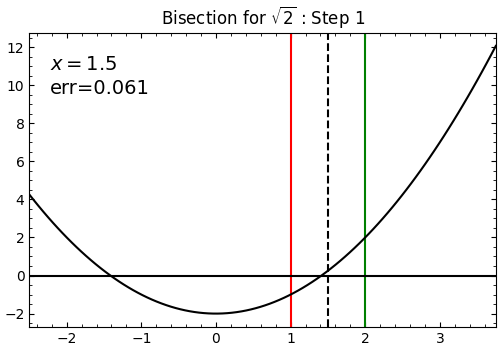

In [5]:
a = [1, -2, 0.1]
b = [2, 3]
AnimateRootFinder(RootBisection, Function_Sqrt2(), a, b)

In [6]:
AnimateRootFinder(RootSecant, Function_Sqrt2(), a, b)

AnimateRootFinder(children=(VBox(children=(Button(description='Reset', style=ButtonStyle(), tooltip='Reset roo…

In [7]:
a = [-1, -2, 0.1]
b = [2, 3]
AnimateRootFinder(RootBisection, Function_Tanh(), a, b)

AnimateRootFinder(children=(VBox(children=(Button(description='Reset', style=ButtonStyle(), tooltip='Reset roo…

In [8]:
AnimateRootFinder(RootSecant, Function_Tanh(), a, b)

AnimateRootFinder(children=(VBox(children=(Button(description='Reset', style=ButtonStyle(), tooltip='Reset roo…

In [9]:
a = [-40, -50, 0.1]
b = [2, 3]
AnimateRootFinder(RootSecant, Function_Tanh(), a, b)

AnimateRootFinder(children=(VBox(children=(Button(description='Reset', style=ButtonStyle(), tooltip='Reset roo…